<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_YoloV3_Custom_DataSpartan_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 - Custom DataSpartan dataset

Notebook to train a YoloV3 model [link](https://github.com/ultralytics/yolov3) with custom dataset generated in the `AIDocs` project of DataSpartan. This dataset is about document segmentation and it is accesible from my profesional drive account (**this is private and not public available**).

This notebook is an adaptation from: [tutorial notebook 1](https://colab.research.google.com/github/ultralytics/yolov3/blob/master/tutorial.ipynb#scrollTo=e5ylFIvlCEym)


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [45]:
import time
import glob
import torch
import os
from IPython.display import Image, clear_output  # to display images

In [46]:
!git clone https://github.com/ultralytics/yolov3  # clone repo
!pip install -r yolov3/requirements.txt  # install dependencies
%cd yolov3

clear_output()

In [47]:
yolo_folderpath = "/content/yolov3"

In [48]:
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## Custom dataset

This dataset is accesible from my profesional driver account (**this is not public available**)

This database is a zip file with a folder with images and other folder with label texts. 

In particular, the format of these annotation documents follow the [`darknet format`](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data)

In this code we download and unzip this file. Then, we split the annotation in `train` and `validation` folders. Finally, we create the metadata files with the information to the yolo model.

[More info](https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data)

#### Download the annotated examples

Connect with my drive (@dataspartan)

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Untar the driver's yolo zip

In [50]:
# Export dataset filepath
dataset_folderpath = "/content/yolo/"

In [51]:
!rm -R {dataset_folderpath}

In [52]:
from pathlib import Path
def mkdir(sfolderpath):
  folderpath = Path(sfolderpath)
  folderpath.mkdir(parents=True, exist_ok=True)

mkdir(dataset_folderpath)

In [53]:
!tar -xvf /content/drive/My\ Drive/DATASPARTAN/PROYECTOS/AI-DOCUMENTS/SEGMENTATION/export..2020.07.02.tar.gz -C {dataset_folderpath}


clear_output()

!ls {dataset_folderpath}

image  yolo_data.yaml  yolo_labels


In [54]:
from os import path
from os import listdir
from os.path import isfile, join

# TEST all the labels to know if they follow the standard structure
yolo_labels_path = os.path.join(dataset_folderpath, "yolo_labels")
filepaths = [join(yolo_labels_path, f) for f in listdir(yolo_labels_path) if isfile(join(yolo_labels_path, f))]

valid_checks = 0
valid_file_checks = 0
for filepath in filepaths:
  if not os.path.isfile(filepath):
    continue
  with open(filepath, 'r') as f:
    valid_file_checks += 1
    line = f.readline()
    while line:
        line = f.readline()
        if len(line) == 0:
          continue

        parts = line.split(" ")

        if len(parts) != 5:
          print(f"Less {line}: {filename}")
          continue

        cls = parts[0]

        try:        
          if int(cls) > 5:
            print(f"CLS {cls} : {filename}")
            continue
          valid_checks += 1
        except:
          print(f"Except {cls} : {filename}")

print(f"Exist {len(filepaths)} label files")
print(f"Revised {valid_file_checks} label files")
print(f"Revised {valid_checks} annotation labels")

Exist 3211 label files
Revised 3211 label files
Revised 28796 annotation labels


Split the yolo labels and images in sub folders to be processed by the yolo model

In [55]:
from os import path
from os import listdir
from os.path import isfile, join

path_images = join(dataset_folderpath, "image")
path_labels = join(dataset_folderpath, "yolo_labels")

def get_processable_filenames(doc_image_path: str, doc_mask_path: str):
    img_filenames = [path.splitext(f)[0] for f in listdir(doc_image_path) if isfile(join(doc_image_path, f))]
    label_filenames = [path.splitext(f)[0] for f in listdir(doc_mask_path) if isfile(join(doc_mask_path, f))]
    img_filenames.sort()
    label_filenames.sort()
    filenames = list(set(img_filenames) & set(label_filenames)) # Intersection
    return filenames
filenames = get_processable_filenames(path_images, path_labels)
print(f'Number of examples: {len(filenames)}')

Number of examples: 3211


In [56]:
import os
for filename in filenames:
  if not isfile( os.path.join(path_images, filename + ".png") ):
    print(filename)

In [57]:
import random
random.shuffle(filenames)
percent = 0.7

pox_break = int(len(filenames)*percent)
train_filenames = filenames[0:pox_break]
val_filenames = filenames[pox_break:]

print(f"Number of training examples : {len(train_filenames)}")
print(f"Number of validation examples : {len(val_filenames)}")

Number of training examples : 2247
Number of validation examples : 964


In [58]:
path_train_images = join(dataset_folderpath, "train/images")
path_train_labels = join(dataset_folderpath, "train/labels") 
path_val_images = join(dataset_folderpath, "val/images") 
path_val_labels = join(dataset_folderpath, "val/labels")  

mkdir(path_train_images)
mkdir(path_train_labels)
mkdir(path_val_images)
mkdir(path_val_labels)

In [59]:
! ls {dataset_folderpath}

image  train  val  yolo_data.yaml  yolo_labels


In [60]:
import shutil
import os

def move_filenames(filenames, path_images, path_labels, path_destination_images, path_destination_labels):

  for filename in filenames:

    if not isfile( os.path.join(path_images, filename + ".png") ):
      continue
    if not isfile( os.path.join(path_labels, filename + ".txt") ):
      continue

    shutil.move( os.path.join(path_images, filename + ".png"),
                os.path.join(path_destination_images, filename + ".png"))
    shutil.move( os.path.join(path_labels, filename + ".txt"),
                os.path.join(path_destination_labels, filename + ".txt"))
  
move_filenames(train_filenames, path_images, path_labels, path_train_images, path_train_labels )
move_filenames(val_filenames, path_images, path_labels, path_val_images, path_val_labels )

In [61]:
tra_files = [path.splitext(f)[0] for f in listdir(path_train_images) if isfile(join(path_train_images, f))]
val_files = [path.splitext(f)[0] for f in listdir(path_val_images) if isfile(join(path_val_images, f))]
print(f"Number of training examples {len(tra_files)}")
print(f"Number of validation examples {len(val_files)}")

Number of training examples 2247
Number of validation examples 964


In [62]:
!rm {path_images} -R
!rm {path_labels} -R

!ls {dataset_folderpath}

train  val  yolo_data.yaml


### Metadata files to the Yolo V3 model

https://github.com/ultralytics/yolov3/wiki/Train-Custom-Data

In [63]:
train_txt_filepath = "/content/yolo/train.txt"

with open(train_txt_filepath, 'w') as f:
  for tra_file in tra_files:
      f.write(f'{os.path.join(path_train_images, tra_file)}.png \n')

In [64]:
val_txt_filepath = "/content/yolo/val.txt"

with open(val_txt_filepath, 'w') as f:
  for val_file in val_files:
      f.write(f'{os.path.join(path_val_images, val_file)}.png \n')

In [65]:
names_filepath = "/content/yolo/cls.names"
with open(names_filepath, 'w') as f:
    f.write(f'background\n')
    f.write(f'text\n')
    f.write(f'title\n')
    f.write(f'list\n')
    f.write(f'table\n')
    f.write(f'figure\n')
    f.write(f'unknown\n')

Generate the `yolo.data` with the metadata about the dataset to the model.

In [66]:
yolo_filepath = "/content/yolo/yolo.data"
with open(yolo_filepath, 'w') as f:
    f.write(f'classes=7 \n')
    # f.write(f'train={train_txt_filepath} \n')
    # f.write(f'valid={val_txt_filepath} \n')
    # f.write(f'names={names_filepath} \n')
    f.write(f'train={path_train_images} \n')
    f.write(f'valid={path_val_images} \n')
    f.write(f'names={names_filepath} \n')

In [67]:
!cat {yolo_filepath}

classes=7 
train=/content/yolo/train/images 
valid=/content/yolo/val/images 
names=/content/yolo/cls.names 


In [68]:
!ls {dataset_folderpath}

cls.names  train  train.txt  val  val.txt  yolo.data  yolo_data.yaml


## Train Yolo v3 model

**NOTE**: I don't know why but the library fails when evaluate the results. The solution patch is add this lines of code:

```
if cls > 5:
  cls = 6
```
the file `/content/yolov3/utils/utils.py` line 920.

In [91]:
%cd /content/yolov3
!python3 train.py --data {yolo_filepath} --img-size 640 --epochs 3 --nosave --batch-size 4

/content/yolov3
Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='cfg/yolov3-spp.cfg', data='/content/yolo/yolo.data', device='', epochs=3, evolve=False, freeze_layers=False, img_size=[640], multi_scale=False, name='', nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-07-08 11:30:39.191538: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
Optimizer groups: 76 .bias, 76 Conv2d.weight, 73 other
Reading image shapes: 100% 2247/2247 [00:19<00:00, 117.26it/s]
Caching labels /content/yolo/train/labels (2247 found, 0

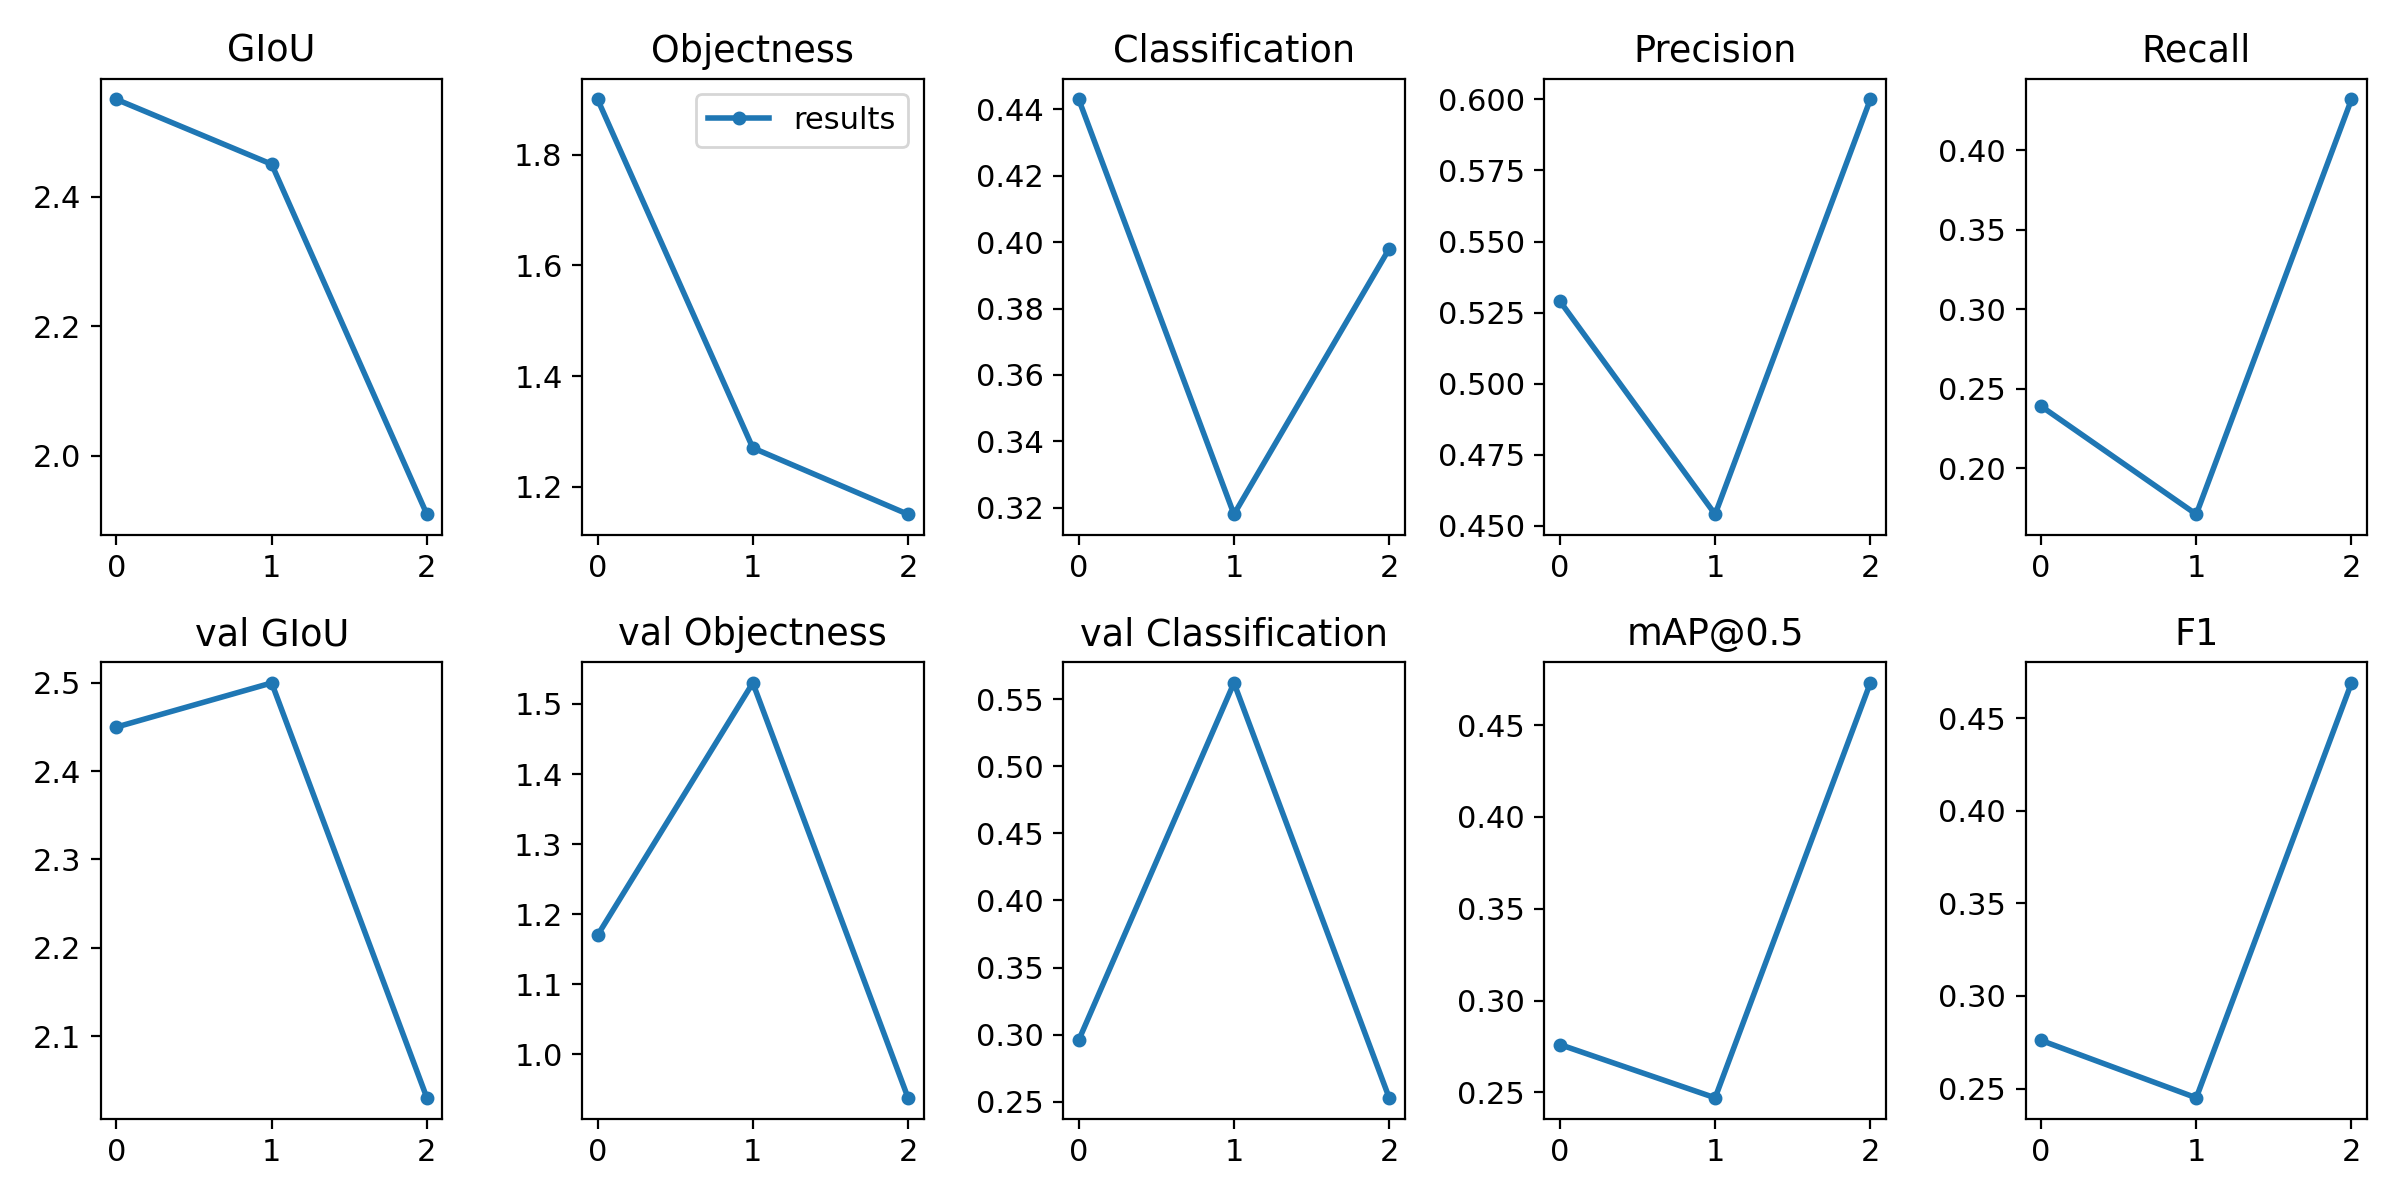

In [94]:
!python3 -c "from utils import utils; utils.plot_results()"  # plot training results
Image(filename='results.png', width=800)

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

GROUND TRUTH TRAINING DATA:


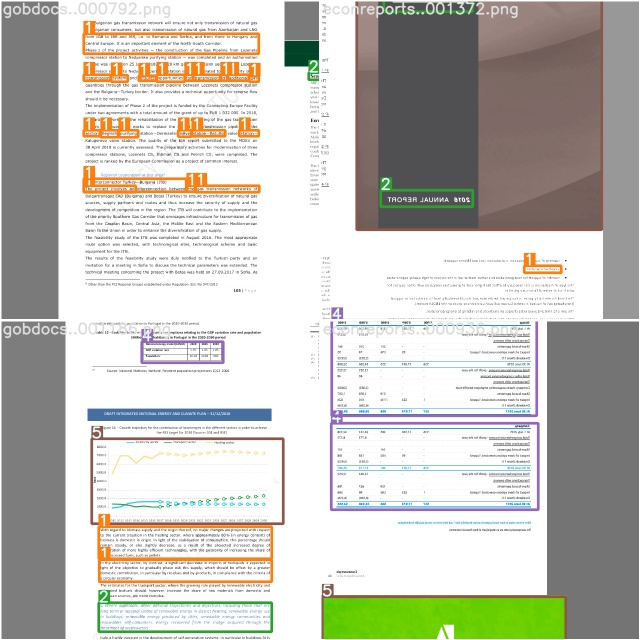

In [106]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
# Image(filename='../test_batch0_gt.jpg', width=900)
Image(filename='./train_batch0.jpg', width=900)

## Test

In [44]:
!python3 test.py --data {yolo_filepath} --save-json --img-size 640 --weights "./weights/yolov3-spp-ultralytics.pt" 

Namespace(augment=False, batch_size=16, cfg='cfg/yolov3-spp.cfg', conf_thres=0.001, data='/content/yolo/yolo.data', device='', img_size=640, iou_thres=0.6, save_json=True, single_cls=False, task='test', weights='./weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Model Summary: 225 layers, 6.29987e+07 parameters, 6.29987e+07 gradients
Fusing layers...
Model Summary: 152 layers, 6.29719e+07 parameters, 6.29719e+07 gradients
Caching labels /content/yolo/val/labels (964 found, 0 missing, 0 empty, 0 duplicate, for 964 images): 100% 964/964 [00:00<00:00, 5405.57it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1:   0% 0/61 [00:02<?, ?it/s]
Traceback (most recent call last):
  File "test.py", line 263, in <module>
    opt.augment)
  File "test.py", line 126, in test
    image_id = int(Path(paths[si]).stem.split('_')[-1])
ValueError: invalid literal for int() with base 10: 'econreports..0008

# Export Trained Weights for Future Inference

Now that you have trained your custom detector, you can export the trained weights you have made here for inference on your device elsewhere

In [92]:
!ls /content/yolov3/weights

download_yolov3_weights.sh  last.pt  yolov3-spp-ultralytics.pt


In [97]:
!cp /content/yolov3/weights/yolov3-spp-ultralytics.pt /content/drive/My\ Drive/yolov3-spp-ultralytics.pt

**Load the weights**

In [40]:
!cp /content/drive/My\ Drive/yolov3-spp-ultralytics.pt /content/yolov3/weights/yolov3-spp-ultralytics.pt 